# Observability Starter for AWS Bedrock models

This accelerator shows how you can easily enable observability in your <a href='https://aws.amazon.com/bedrock/'>AWS Bedrock</a> based Generative AI Solutions with DataRobot's LLMOps feature tools. It outlines an example of a byte-sized solution in its current state and then uses DataRobot tools to enable observability almost instantly for the solution.

DataRobot provides tools to enable the observability of external generative models. All the hallmarks of DataRobot MLOps are now available for LLMOps.

## Setup

### Install the prerequisite libraries

This accelerator uses the recommended installation files instead of PyPi as per the AWS official <a href='https://d2eo22ngex1n9g.cloudfront.net/Documentation/BedrockUserGuide.pdf'>Bedrock documentation</a>. You can use the newer methods of installation if AWS updates the documentation at the time of running this notebook.

In [ ]:
!mkdir storage/bedrock_sdk/
import shutil

import requests

url = "https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk.zip"
r = requests.get(url, allow_redirects=True)
open("storage/bedrock-python-sdk.zip", "wb").write(r.content)
shutil.unpack_archive("storage/bedrock-python-sdk.zip", "storage/bedrock_sdk/")
!pip install storage/bedrock_sdk/botocore-1.31.21-py3-none-any.whl storage/bedrock_sdk/boto3-1.28.21-py3-none-any.whl

Processing ./storage/bedrock_sdk/botocore-1.31.21-py3-none-any.whl
Processing ./storage/bedrock_sdk/boto3-1.28.21-py3-none-any.whl
     |████████████████████████████████| 79 kB 9.4 MB/s 


In [1]:
!pip install datarobotx[llm] datarobot-mlops datarobot-mlops-connected-client transformers "langchain==0.0.335"

In [2]:
!pip install py-readability-metrics nltk

## Current state 

The following cells outline the current state of a simple <a href='https://aws.amazon.com/bedrock/titan/'>AWS Titan-based </a>text generation model implementation. Titan is a foundational model (LLM) built and trained by Amazon. Along with Titan, AWS also provides other LLMs for users to consume whose details are available <a href='https://aws.amazon.com/bedrock/titan/'>here</a>.

Use the Titan (large) model to generate text. The `get_completion` endpoint is used to generate text based on the input prompt. To enable observability on this implementation on your own, you would have to write code to take measurements, enable infrastructure to record all the measurements, and codify rules for interventions. This also introduces a lot of technical debt in the organization. 
<br>
<br>

In [4]:
import json
import os

import boto3

ACCESS_KEY = os.environ["ACCESS_KEY"]
SECRET_KEY = os.environ["SECRET_KEY"]
SESSION_TOKEN = os.environ["SESSION_TOKEN"]

bedrock = boto3.client(
    "bedrock",
    "us-west-2",
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    aws_session_token=SESSION_TOKEN,
)

prompt_data = """
Command: You are an education expert. Please explain the following concept to me as if I am a \
5 year old with examples: """

parameters = {
    "maxTokenCount": 4096,
    # "stopSequences":[],
    "temperature": 0,
    "topP": 0.9,
}

modelId = "amazon.titan-tg1-large"
accept = "application/json"
contentType = "application/json"


def get_completion(user_input, parameters):
    body = json.dumps({"inputText": prompt_data + user_input, "textGenerationConfig": parameters})
    response = bedrock.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    answer = json.loads(response.get("body").read())
    return answer


outputText = get_completion("agile", parameters)
print(outputText.get("results")[0].get("outputText"))


Agile is like a frog. When a frog wants to go somewhere, it doesn't stop and think about everything it will encounter along the way. It jumps and then lands somewhere. Then, it looks around and sees what is in front of it. If it wants to go somewhere else, it jumps again. It keeps doing this until it reaches its destination. 
Projects can be like frogs too. When a project manager wants to complete a project, they don't need to plan everything that will happen step by step. They can just start working on it and keep going until they finish. Then, they will look at what they have done and decide what to do next. If they need to change something, they can just jump to another action like the frog. This way, they can reach their goal successfully.


## Observability with DataRobot
To enable observability on the above Bedrock models from AWS, you first need to create a deployment in DataRobot. This can be done from the GUI or the API based on your preference.

### Connect to DataRobot

In [4]:
# Initialize the DataRobot Client if you are not running this code outside DataRobot platform.
# import datarobot as dr
# dr.Client(endpoint=ENDPOINT,token=TOKEN)

In [5]:
from utilities import create_external_llm_deployment

deployment_id, model_id = create_external_llm_deployment(modelId + " External")

[nltk_data] Downloading package punkt to /home/notebooks/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Initiate monitoring configuration

The cells below declare and initialize monitoring configuration. The monitoring configuration lets DataRobot understand how to interpret the inputs and outputs of the external model. Standard implementation of the hosted Titan object has a <a href='https://docs.aws.amazon.com/bedrock/latest/APIReference/API_InvokeModel.html'>invoke_model</a> endpoint which expects prompt text and json parameters which are configured in the MonitoringConfig object as seen below. 

The <a href="https://drx.datarobot.com/reference/_autosummary/datarobotx.llm.MonitoringConfig.html#monitoringconfig">input_parser</a> object is helpful in capturing and storing the entire input or just the essential parts that you prefer.

In [6]:
from datarobotx.llm.chains.guard import aguard, MonitoringConfig

monitor_config = MonitoringConfig(
    deployment_id=deployment_id,
    model_id=model_id,
    inputs_parser=lambda user_input, parameters: {
        **{"user_input": user_input},
        **parameters,
    },
    output_parser=lambda x: {"answer": x.get("results")[0].get("outputText")},
    target="answer",
)

In [7]:
@aguard(monitor_config)
async def get_completion(user_input, parameters):
    body = json.dumps({"inputText": prompt_data + user_input, "textGenerationConfig": parameters})
    response = bedrock.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    answer = json.loads(response.get("body").read())
    return answer


answer = await get_completion("Agile", parameters)
print(answer.get("results")[0].get("outputText"))


Agile is like a way of working that helps people to do things faster and in a more flexible way. It's like when you play tag, and you have to run and move quickly without stopping.
Let's say you have to build a toy car, but you don't know exactly how it should look or work. With Agile, you can break the process of building the car into smaller parts. You can make one part of the car, like the wheels, and then test it to see if it works well. If it does, you can move on to the next part.
But if the first part doesn't work well, you can change it and try again. This way, you can keep improving the car until it's perfect. Agile is a way of working that helps people to be more creative and to make better products.


## Custom metrics

Observability with DataRobot also supports <a href='https://docs.datarobot.com/en/docs/mlops/deployment-settings/custom-metrics-settings.html'>custom user metrics</a>. The following cells show how you can start capturing toxicity in user prompts and readability in generative model responses. Add the custom metrics in the cell below that you want to record to your deployment. Again, this step can be done using the GUI or the API based on user preference. <br>
- Toxicity in the user prompt <br>
- Readability (Flesch Score) of the model response 

In [8]:
from utilities import create_custom_metric

TOX_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Prompt Toxicity",
    baseline="0.1",
    type="average",
    directionality="lowerIsBetter",
)

READ_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Response Readability",
    baseline="30",
    type="average",
    directionality="higherIsBetter",
)

### Update the Bedrock completion endpoint

Modify the prediction function to add code that calculates the metrics and submits them to the deployment. Now, whenever the prediction is requested from the Titan model, the metrics are calculated and submitted on the deployment enabling you to monitor and intervene as necessary.

In [9]:
from utilities import get_flesch_score, get_text_texicity, submit_custom_metric


@aguard(monitor_config)
async def get_completion(user_input, parameters):
    body = json.dumps({"inputText": prompt_data + user_input, "textGenerationConfig": parameters})
    response = bedrock.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    answer = json.loads(response.get("body").read())
    try:
        submit_custom_metric(
            deployment_id,
            READ_CUSTOM_METRIC_ID,
            get_flesch_score(answer.get("results")[0].get("outputText")),
        )
        submit_custom_metric(deployment_id, TOX_CUSTOM_METRIC_ID, get_text_texicity(user_input))
    except Exception as e:
        print(e)
        pass
    return answer


answer = await get_completion("Agile", parameters)
print(answer.get("results")[0].get("outputText"))


Agile is like a way of working that helps people to do things faster and in a more flexible way. It's like when you play tag, and you have to run and move quickly without stopping.
Let's say you have to build a toy car, but you don't know exactly how it should look or work. With Agile, you can break the process of building the car into smaller parts. You can make one part of the car, like the wheels, and then test it to see if it works well. If it does, you can move on to the next part.
But if the first part doesn't work well, you can change it and try again. This way, you can keep improving the car until it's perfect. Agile is a way of working that helps people to be more creative and to make better products.


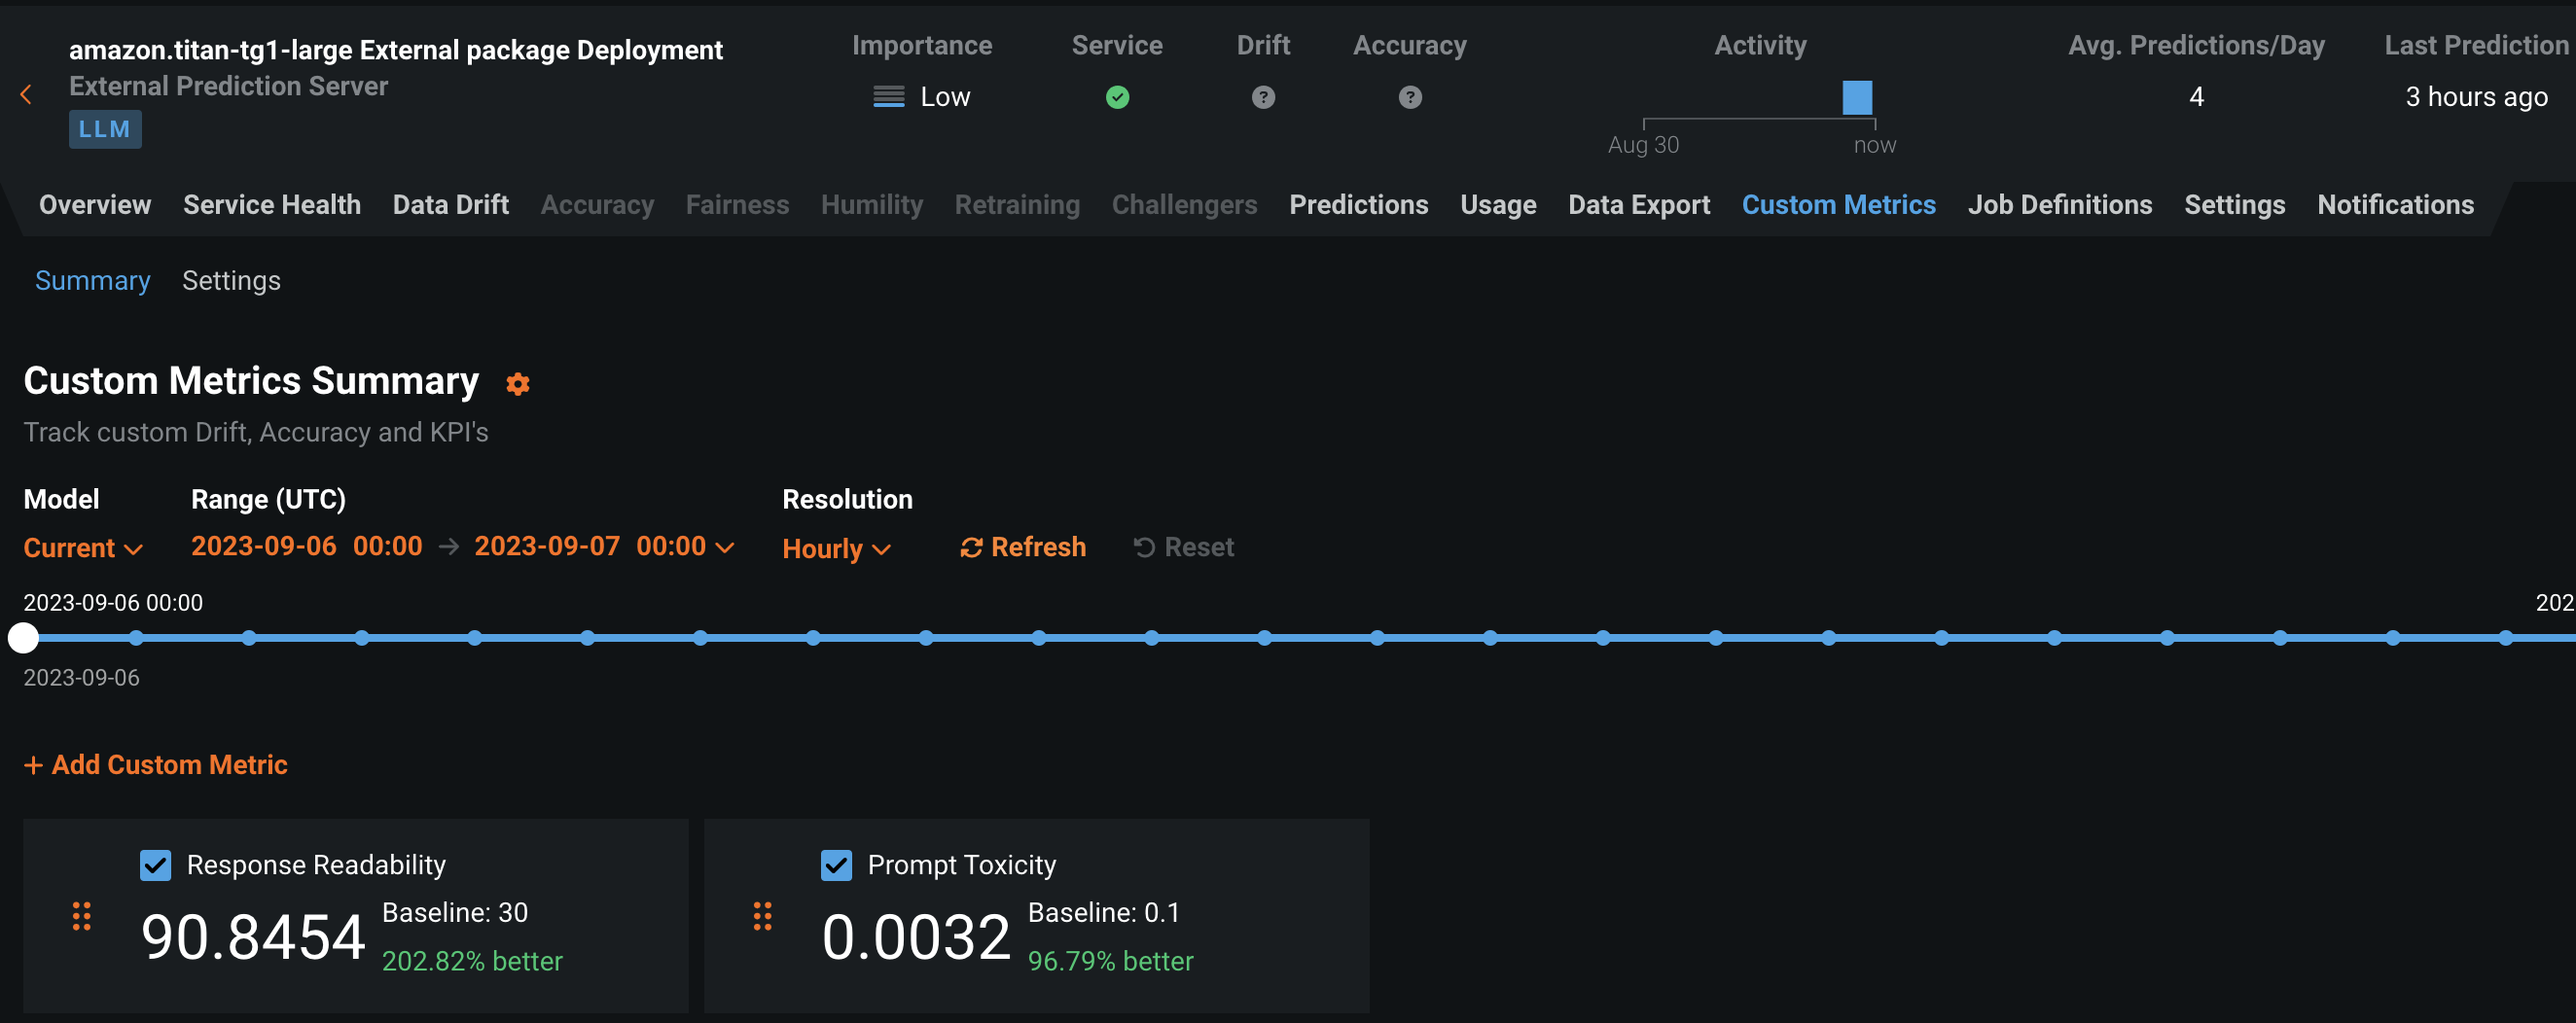

## Conclusion

Using DataRobot's tools for LLMOps, you can implement observability for AWS Bedrock based applications easily with easily with less friction while avoiding increased technical debt.